## 0. Basic

### Display the some first `image_file_names` & `file_name.csv`

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

## print out the names of the first 5 image_files (total = 10 images for train_imgaes & train_label_masks) with the train, test, submission.csv files
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames[:5]:
        print(os.path.join(dirname, filename))

/kaggle/input/prostate-cancer-grade-assessment/sample_submission.csv
/kaggle/input/prostate-cancer-grade-assessment/test.csv
/kaggle/input/prostate-cancer-grade-assessment/train.csv
/kaggle/input/prostate-cancer-grade-assessment/train_images/2673584f9398ce0acb21a86a1a711088.tiff
/kaggle/input/prostate-cancer-grade-assessment/train_images/5d46da93924a4b15472581eb39658309.tiff
/kaggle/input/prostate-cancer-grade-assessment/train_images/35e8dd323072ad8efa1ae1db44921669.tiff
/kaggle/input/prostate-cancer-grade-assessment/train_images/a807e743ad2020d229347aede1882a8f.tiff
/kaggle/input/prostate-cancer-grade-assessment/train_images/95c518378ccd428a5e674c3c668e9f2e.tiff
/kaggle/input/prostate-cancer-grade-assessment/train_label_masks/9bce8bb47c22ab502ed7266e2e3762c0_mask.tiff
/kaggle/input/prostate-cancer-grade-assessment/train_label_masks/124a0616099409f5b9aaedfd3ac3ab6d_mask.tiff
/kaggle/input/prostate-cancer-grade-assessment/train_label_masks/8b1590bb6429c7b3bbbcf0a420fff72d_mask.tiff
/kag

### Basic libraries

In [2]:
import os

# There are two ways to load the data from the PANDA dataset:
# Option 1: Load images using openslide
import openslide
# Option 2: Load images using skimage (requires that tifffile is installed)
import skimage.io
import random
import seaborn as sns
import cv2

# General packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import PIL
from IPython.display import Image, display

# Plotly for the interactive viewer (see last section)
import plotly.graph_objs as go

### Loading & viewing dataset

In [3]:
# Location of the training images

BASE_PATH = '../input/prostate-cancer-grade-assessment'

# image and mask directories
data_dir = f'{BASE_PATH}/train_images'
mask_dir = f'{BASE_PATH}/train_label_masks'


# Location of training labels
train = pd.read_csv(f'{BASE_PATH}/train.csv').set_index('image_id')
test = pd.read_csv(f'{BASE_PATH}/test.csv')

train_labels = pd.read_csv('/kaggle/input/prostate-cancer-grade-assessment/train.csv').set_index('image_id')

submission = pd.read_csv(f'{BASE_PATH}/sample_submission.csv')

In [4]:
train.head()

data_provider  isup_grade gleason_score
image_id                                                                
0005f7aaab2800f6170c399693a96917    karolinska           0           0+0
000920ad0b612851f8e01bcc880d9b3d    karolinska           0           0+0
0018ae58b01bdadc8e347995b69f99aa       radboud           4           4+4
001c62abd11fa4b57bf7a6c603a11bb9    karolinska           4           4+4
001d865e65ef5d2579c190a0e0350d8f    karolinska           0           0+0

In [5]:
print("Shape of training data :", train.shape)
print("Mainly information of training data :", train.info())
print("unique data provider :", len(train.data_provider.unique()))
print("unique isup_grade(target) :", len(train.isup_grade.unique()))
print("unique gleason_score :", len(train.gleason_score.unique()))

Shape of training data : (10616, 3)
<class 'pandas.core.frame.DataFrame'>
Index: 10616 entries, 0005f7aaab2800f6170c399693a96917 to ffe9bcababc858e04840669e788065a1
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   data_provider  10616 non-null  object
 1   isup_grade     10616 non-null  int64 
 2   gleason_score  10616 non-null  object
dtypes: int64(1), object(2)
memory usage: 331.8+ KB
Mainly information of training data : None
unique data provider : 2
unique isup_grade(target) : 6
unique gleason_score : 11


In [6]:
test.head()

image_id data_provider
0  005700be7e06878e6605e7a5a39de1b2       radboud
1  005c6e8877caf724c600fdce5d417d40    karolinska
2  0104f76634ff89bfff1ef0804a95c380       radboud

In [7]:
submission.head()

image_id  isup_grade
0  005700be7e06878e6605e7a5a39de1b2           0
1  005c6e8877caf724c600fdce5d417d40           0
2  0104f76634ff89bfff1ef0804a95c380           0

## 1. Image_information: `shape, level_downsample & memory_size`

image_ID: 004dd32d9cd167d9cc31c13b704498af
Source: radboud 	ISUP: 1 	Gleason: 3+3
Level_downsample: 1 	 data_img_shape(w, h) with openslide:  (8192, 22528) , 	 data_img_shape(h, w) with ski: (22528, 8192, 3)
	 	 	 mask_img_shape(w, h) with openslide:  (8192, 22528) , 	 mask_img_shape(h, w) with ski: (22528, 8192, 3)
	 	 	 data_img: 	 min_pixel_value: 0 	 max_pixel_value: 255 , 	 memory size:  528  MB
	 	 	 mask_img: 	 min_pixel_value: 0 	 max_pixel_value: 2 , 		 memory size:  528.0 MB 

Level_downsample: 4 	 data_img_shape(w, h) with openslide:  (2048, 5632) , 	 data_img_shape(h, w) with ski: (5632, 2048, 3)
	 	 	 mask_img_shape(w, h) with openslide:  (2048, 5632) , 	 mask_img_shape(h, w) with ski: (5632, 2048, 3)
	 	 	 data_img: 	 min_pixel_value: 0 	 max_pixel_value: 255 , 	 memory size:  33  MB
	 	 	 mask_img: 	 min_pixel_value: 0 	 max_pixel_value: 2 , 		 memory size:  33.0 MB 

Level_downsample: 16 	 data_img_shape(w, h) with openslide:  (512, 1408) , 	 data_img_shape(h, w) with s

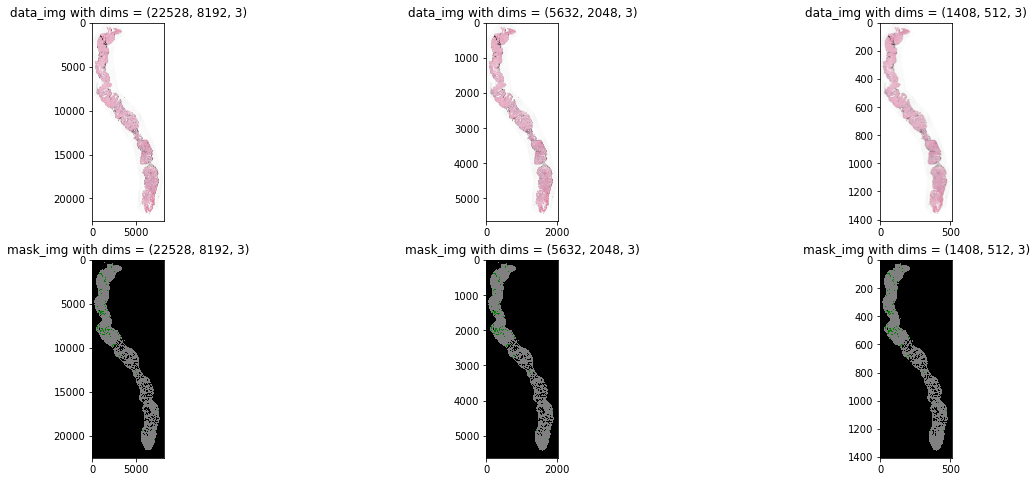

In [8]:
import skimage

def image_info(img_id):    
    
    ## read the images
    img_data = skimage.io.MultiImage(os.path.join(data_dir, f'{img_id}.tiff'))
    img_mask = skimage.io.MultiImage(os.path.join(mask_dir, f'{img_id}_mask.tiff'))
    image = openslide.OpenSlide(os.path.join(data_dir, f'{img_id}.tiff'))
    
    ## image_id, data_provider & score / grade 
    image_id = img_id
    data_provider = train.loc[img_id, 'data_provider']
    isup_grade = train.loc[img_id, 'isup_grade']
    gleason_score = train.loc[img_id, 'gleason_score']
    print(f"image_ID: {image_id}\nSource: {data_provider} \tISUP: {isup_grade} \tGleason: {gleason_score}")
    
    ## print the main_image_infomation
    for idx, level in enumerate(img_mask):
        print('Level_downsample:', str(int(image.level_downsamples[idx])), '\t data_img_shape(w, h) with openslide: ',
              image.level_dimensions[idx], ', \t data_img_shape(h, w) with ski:', img_data[idx].shape)
        print('\t \t \t mask_img_shape(w, h) with openslide: ',
              image.level_dimensions[idx], ', \t mask_img_shape(h, w) with ski:', img_mask[idx].shape)
        print('\t \t \t data_img: \t min_pixel_value:', img_mask[idx].min(), '\t max_pixel_value:', img_data[idx].max(), 
              ', \t memory size: ', int(img_data[idx].nbytes / (2**20)), ' MB')
        print('\t \t \t mask_img: \t min_pixel_value:', img_mask[idx].min(), '\t max_pixel_value:', img_mask[idx].max(),
              ', \t\t memory size: ', round(level.nbytes/ (2**20), 1), 'MB \n')

    ## display; since the pixel_value of the img_mask is in [0, 2]; so we put it into the cmap
    cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])
    plt.figure(figsize = (20, 8))
    for k in range(len(img_mask)):
        plt.subplot(2, 3, k+4)
        plt.imshow(img_mask[k][:,:,0], cmap=cmap, interpolation='nearest', vmin=0, vmax=5)
        plt.title('mask_img with dims = ' + str(img_mask[k].shape))
        plt.subplot(2, 3, k+1)
        plt.imshow(img_data[k])
        plt.title('data_img with dims = ' + str(img_data[k].shape))

%time image_info('004dd32d9cd167d9cc31c13b704498af')

And the next one is for the `image_id = '07a7ef0ba3bb0d6564a73f4f3e1c2293'`

image_ID: 07a7ef0ba3bb0d6564a73f4f3e1c2293
Source: karolinska 	ISUP: 4 	Gleason: 4+4
Level_downsample: 1 	 data_img_shape(w, h) with openslide:  (24900, 29228) , 	 data_img_shape(h, w) with ski: (29228, 24900, 3)
	 	 	 mask_img_shape(w, h) with openslide:  (24900, 29228) , 	 mask_img_shape(h, w) with ski: (29228, 24900, 3)
	 	 	 data_img: 	 min_pixel_value: 0 	 max_pixel_value: 255 , 	 memory size:  2082  MB
	 	 	 mask_img: 	 min_pixel_value: 0 	 max_pixel_value: 2 , 		 memory size:  2082.2 MB 

Level_downsample: 4 	 data_img_shape(w, h) with openslide:  (6225, 7307) , 	 data_img_shape(h, w) with ski: (7307, 6225, 3)
	 	 	 mask_img_shape(w, h) with openslide:  (6225, 7307) , 	 mask_img_shape(h, w) with ski: (7307, 6225, 3)
	 	 	 data_img: 	 min_pixel_value: 0 	 max_pixel_value: 255 , 	 memory size:  130  MB
	 	 	 mask_img: 	 min_pixel_value: 0 	 max_pixel_value: 2 , 		 memory size:  130.1 MB 

Level_downsample: 16 	 data_img_shape(w, h) with openslide:  (1556, 1826) , 	 data_img_shape(

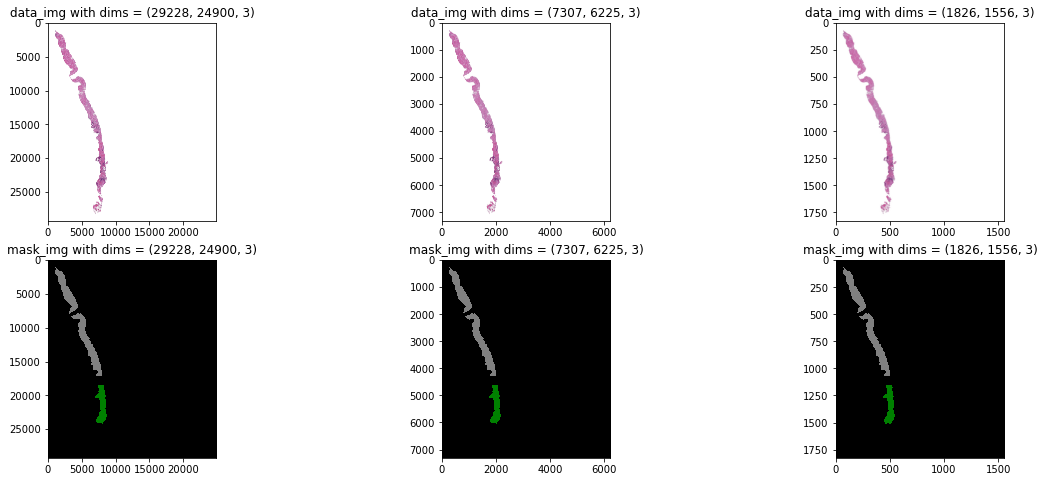

In [9]:
%time image_info('07a7ef0ba3bb0d6564a73f4f3e1c2293')

image_ID: 046b35ae95374bfb48cdca8d7c83233f
Source: radboud 	ISUP: 5 	Gleason: 4+5
Level_downsample: 1 	 data_img_shape(w, h) with openslide:  (5888, 11776) , 	 data_img_shape(h, w) with ski: (11776, 5888, 3)
	 	 	 mask_img_shape(w, h) with openslide:  (5888, 11776) , 	 mask_img_shape(h, w) with ski: (11776, 5888, 3)
	 	 	 data_img: 	 min_pixel_value: 0 	 max_pixel_value: 255 , 	 memory size:  198  MB
	 	 	 mask_img: 	 min_pixel_value: 0 	 max_pixel_value: 5 , 		 memory size:  198.4 MB 

Level_downsample: 4 	 data_img_shape(w, h) with openslide:  (1472, 2944) , 	 data_img_shape(h, w) with ski: (2944, 1472, 3)
	 	 	 mask_img_shape(w, h) with openslide:  (1472, 2944) , 	 mask_img_shape(h, w) with ski: (2944, 1472, 3)
	 	 	 data_img: 	 min_pixel_value: 0 	 max_pixel_value: 255 , 	 memory size:  12  MB
	 	 	 mask_img: 	 min_pixel_value: 0 	 max_pixel_value: 5 , 		 memory size:  12.4 MB 

Level_downsample: 16 	 data_img_shape(w, h) with openslide:  (368, 736) , 	 data_img_shape(h, w) with sk

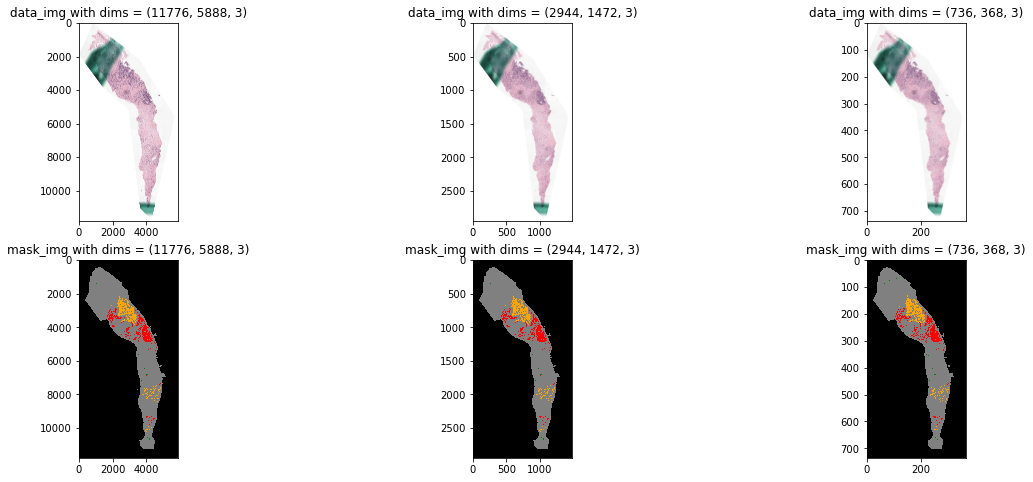

In [10]:
%time image_info('046b35ae95374bfb48cdca8d7c83233f')

and `img_id = '068b0e3be4c35ea983f77accf8351cc8'`

image_ID: 068b0e3be4c35ea983f77accf8351cc8
Source: radboud 	ISUP: 3 	Gleason: 4+3
Level_downsample: 1 	 data_img_shape(w, h) with openslide:  (26368, 9728) , 	 data_img_shape(h, w) with ski: (9728, 26368, 3)
	 	 	 mask_img_shape(w, h) with openslide:  (26368, 9728) , 	 mask_img_shape(h, w) with ski: (9728, 26368, 3)
	 	 	 data_img: 	 min_pixel_value: 0 	 max_pixel_value: 255 , 	 memory size:  733  MB
	 	 	 mask_img: 	 min_pixel_value: 0 	 max_pixel_value: 4 , 		 memory size:  733.9 MB 

Level_downsample: 4 	 data_img_shape(w, h) with openslide:  (6592, 2432) , 	 data_img_shape(h, w) with ski: (2432, 6592, 3)
	 	 	 mask_img_shape(w, h) with openslide:  (6592, 2432) , 	 mask_img_shape(h, w) with ski: (2432, 6592, 3)
	 	 	 data_img: 	 min_pixel_value: 0 	 max_pixel_value: 255 , 	 memory size:  45  MB
	 	 	 mask_img: 	 min_pixel_value: 0 	 max_pixel_value: 4 , 		 memory size:  45.9 MB 

Level_downsample: 16 	 data_img_shape(w, h) with openslide:  (1648, 608) , 	 data_img_shape(h, w) with s

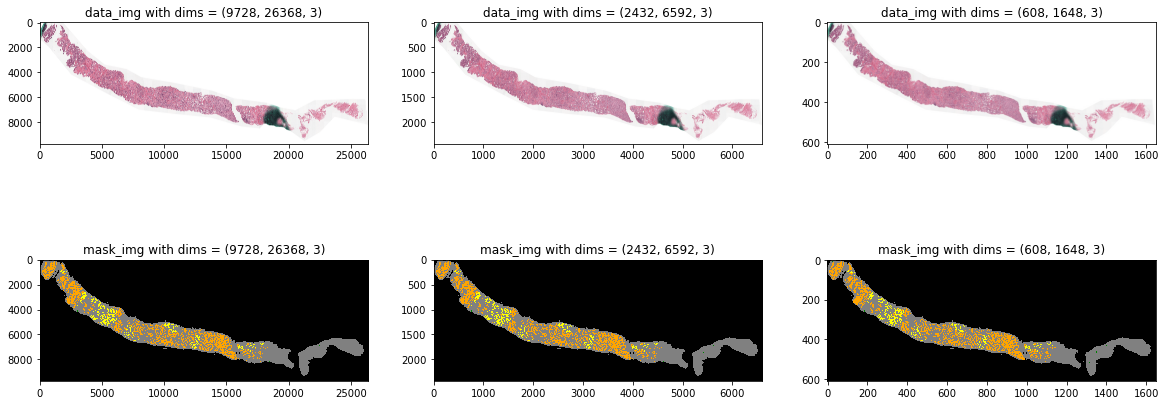

In [11]:
%time image_info('068b0e3be4c35ea983f77accf8351cc8')

So, we we can use the last dimension to reduce the `CPUmemory`

In [12]:
import skimage
img = skimage.io.MultiImage(os.path.join(data_dir, '004dd32d9cd167d9cc31c13b704498af.tiff'))[-1]
img.shape

(1408, 512, 3)

## 2. spliting_image with various level.

In [13]:
def spliting_image_v3(img_id, level = 0, crit = 0.005):
    """
    Input:  img_id (str): image_id from the train dataset, such as '004dd32d9cd167d9cc31c13b704498af'  
            level (int): {0, 1, 2} corresponding to lv_downsample = {1, 4, 16}
            crit (float) in (0, 1): the proportion of the dark_region over whole image (size 256 x 256)
    return: list of images size 256x256
    """
    img = skimage.io.MultiImage(os.path.join(data_dir, f'{img_id}.tiff'))[level]
    im_msk = skimage.io.MultiImage(os.path.join(mask_dir, f'{img_id}_mask.tiff'))[level]
    
    hs, ws = int(256/(2**(2*level))), int(256/(2**(2*level)))
    h, w = img.shape[: 2]
    nc = int(w / ws)
    nr = int(h / hs)
    img_ls = []
    ims_ls = []
    
    for i in range(nr):
        for j in range(nc):
            image_dt = img[ int(i*hs) : int((i+1)*hs), int(j*ws) : int((j+1)*ws), :]
            image_ms = im_msk[ int(i*hs) : int((i+1)*hs), int(j*ws) : int((j+1)*ws), :]
            if (image_dt.min() < 145):
                count = len(image_dt[image_dt <= 50])
                if count/(ws*hs*3) > crit:
                    image_dt = cv2.resize(image_dt, (256, 256), interpolation = cv2.INTER_AREA)
                    image_ms = cv2.resize(image_ms, (256, 256), interpolation = cv2.INTER_AREA)
                    img_ls.append(image_dt)
                    ims_ls.append(image_ms)
                
    return img_ls, ims_ls
        
%time y0, y0_ms = spliting_image_v3('004dd32d9cd167d9cc31c13b704498af', 0, 0.0045)
y0_arr = np.array(y0)
len(y0), y0[0].shape, type(y0), y0_arr.shape, y0[0].min(), y0[0].max()

CPU times: user 2.4 s, sys: 763 ms, total: 3.17 s
Wall time: 2.01 s


(233, (256, 256, 3), list, (233, 256, 256, 3), 1, 255)

**Random display images**

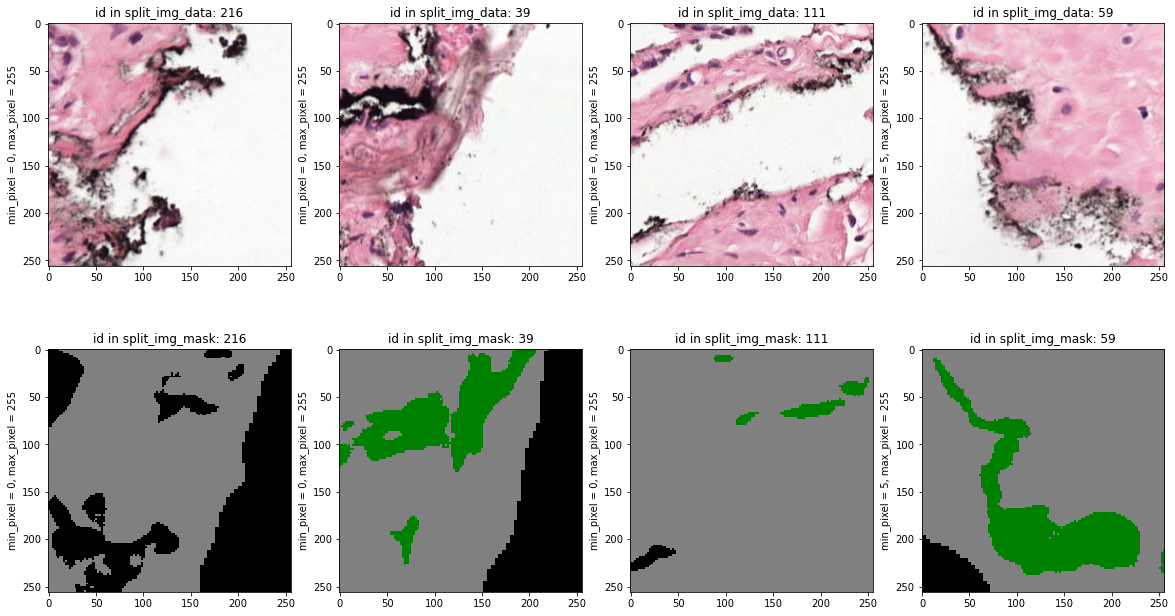

In [14]:
plt.figure(figsize = (20, 11))
cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])
for i in range(4):
    idx = np.random.randint(0, len(y0))   
    plt.subplot(2, 4, i + 1)
    plt.imshow(y0[idx])
    plt.ylabel('min_pixel = ' + str(y0[idx].min()) + ', max_pixel = ' + str(y0[idx].max()))
    plt.title('id in split_img_data: ' + str(idx))
    
    plt.subplot(2, 4, i + 5)
    plt.imshow(y0_ms[idx][:,:,0], cmap=cmap, interpolation='nearest', vmin=0, vmax=5)
    plt.title('id in split_img_mask: ' + str(idx))
    plt.ylabel('min_pixel = ' + str(y0[idx].min()) + ', max_pixel = ' + str(y0[idx].max()))

### 2.1 Firstly, using `level_downsample = 16`

In [15]:
%time y2, y2_ms = spliting_image_v3('004dd32d9cd167d9cc31c13b704498af', 2, 0.0045)
y2_arr = np.array(y2)
len(y2), y2[0].shape, type(y2), y2_arr.shape, y2[0].min(), y2[0].max()

CPU times: user 49.4 ms, sys: 12.8 ms, total: 62.1 ms
Wall time: 66.2 ms


(57, (256, 256, 3), list, (57, 256, 256, 3), 14, 255)

In [16]:
help(spliting_image_v3)

Help on function spliting_image_v3 in module __main__:

spliting_image_v3(img_id, level=0, crit=0.005)
    Input:  img_id (str): image_id from the train dataset, such as '004dd32d9cd167d9cc31c13b704498af'  
            level (int): {0, 1, 2} corresponding to lv_downsample = {1, 4, 16}
            crit (float) in (0, 1): the proportion of the dark_region over whole image (size 256 x 256)
    return: list of images size 256x256



#### Display split_img

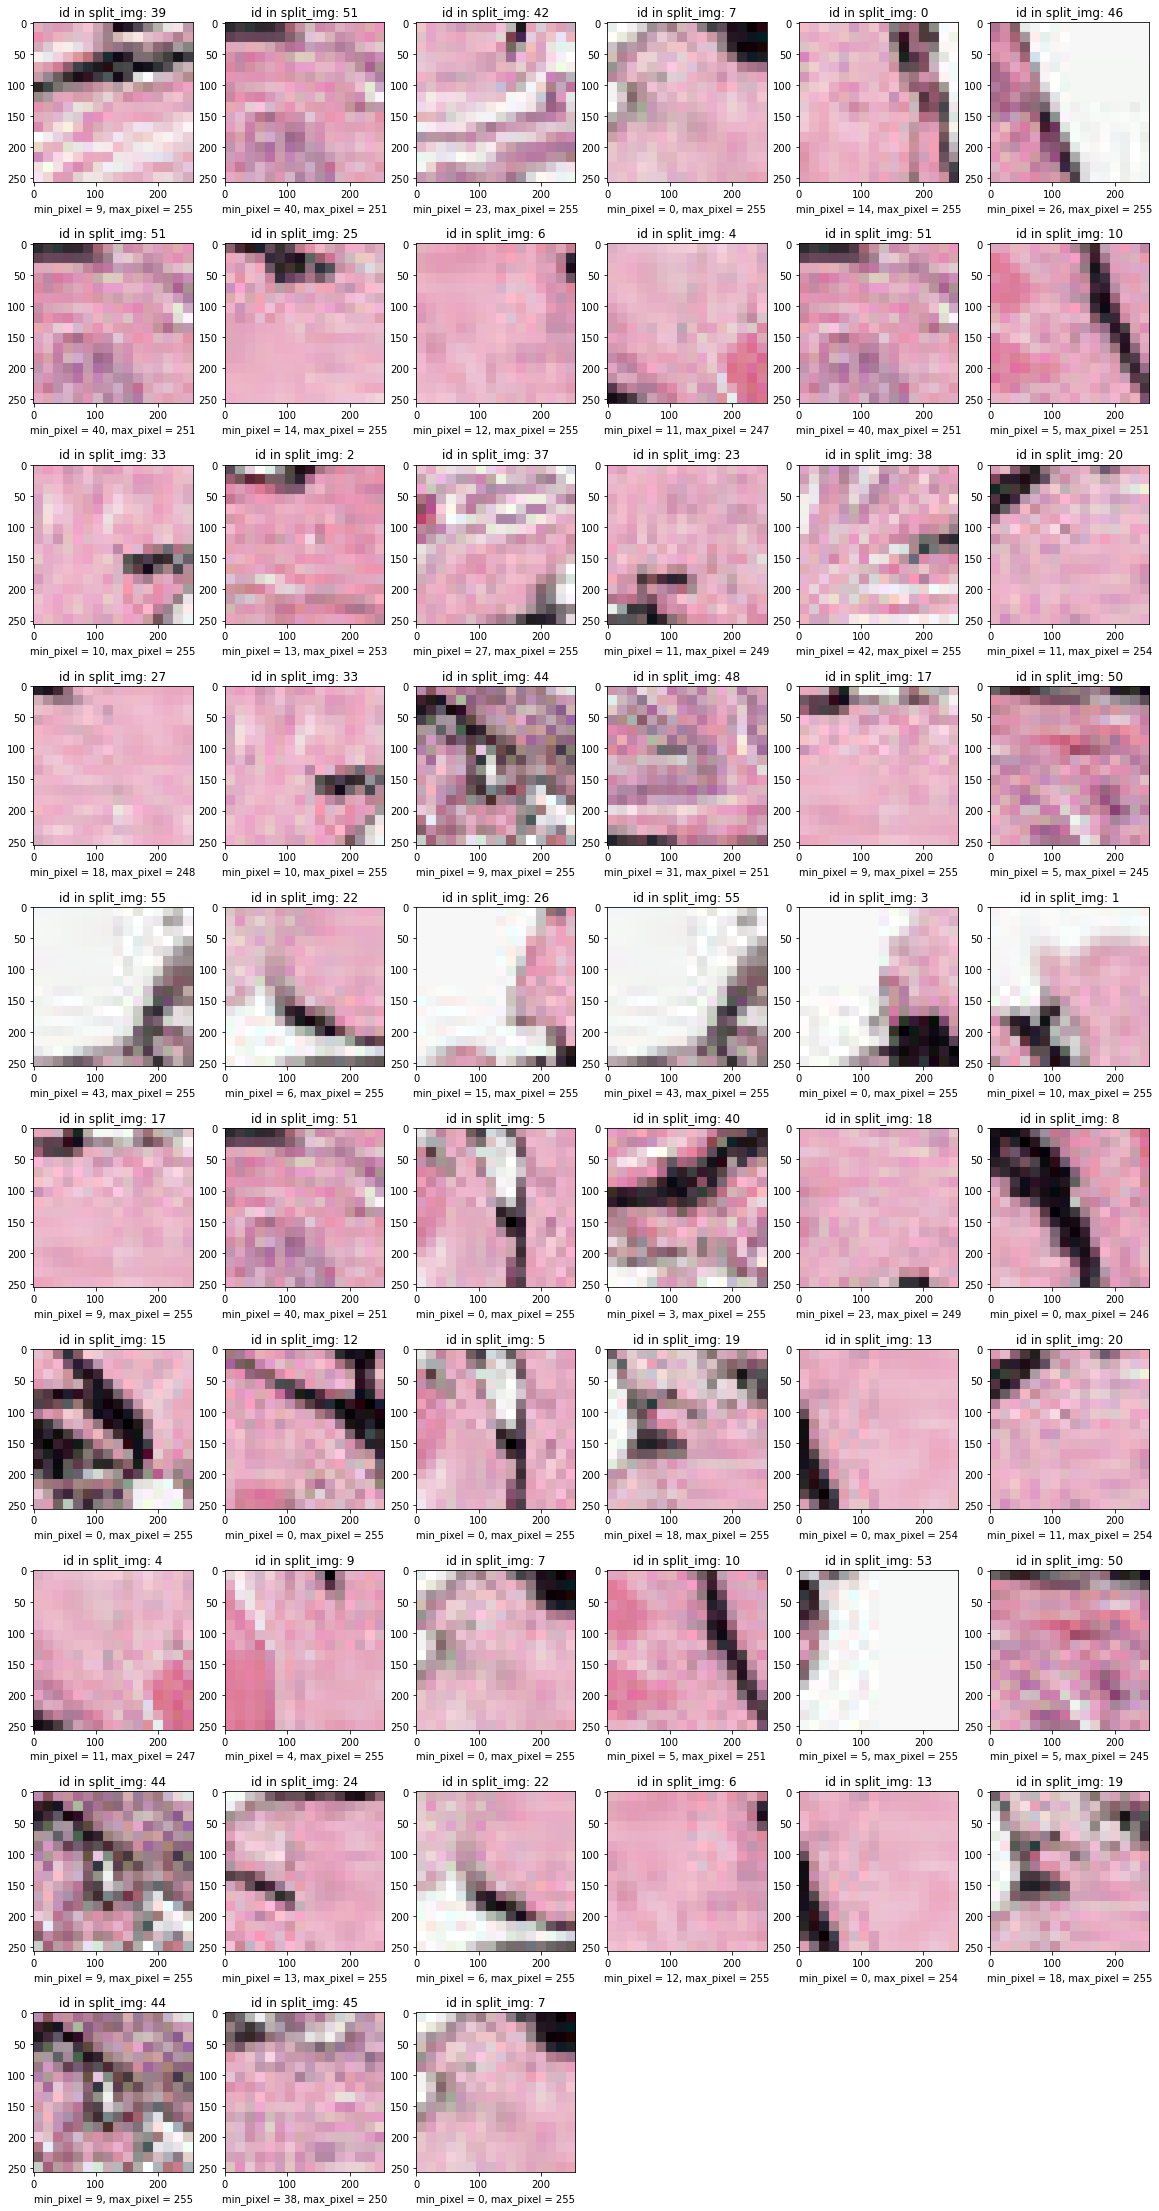

In [17]:
plt.figure(figsize = (20, 40))
for i in range(len(y2)):
    idx = np.random.randint(0, len(y2))
    plt.subplot(np.ceil(len(y2)/6), 6, i + 1)
    plt.imshow(y2[idx])
    plt.title('id in split_img: ' + str(idx))
    plt.xlabel('min_pixel = ' + str(y2[idx].min()) + ', max_pixel = ' + str(y2[idx].max()))

The `resolution` is not good at `level = 2`, which corresponding to `level_downsamples = 16`! So we will try with `level = 1`

### 2.2. For `level = 1` (`level_downsamples = 16`)

In [18]:
%time y1, y1_ms = spliting_image_v3('004dd32d9cd167d9cc31c13b704498af', 1, 0.0045)
y1_arr = np.array(y1)
len(y1), y1[0].shape, type(y1), y1_arr.shape, y1[0].min(), y1[0].max()

CPU times: user 244 ms, sys: 62 ms, total: 306 ms
Wall time: 224 ms


(158, (256, 256, 3), list, (158, 256, 256, 3), 0, 255)

**Random display**

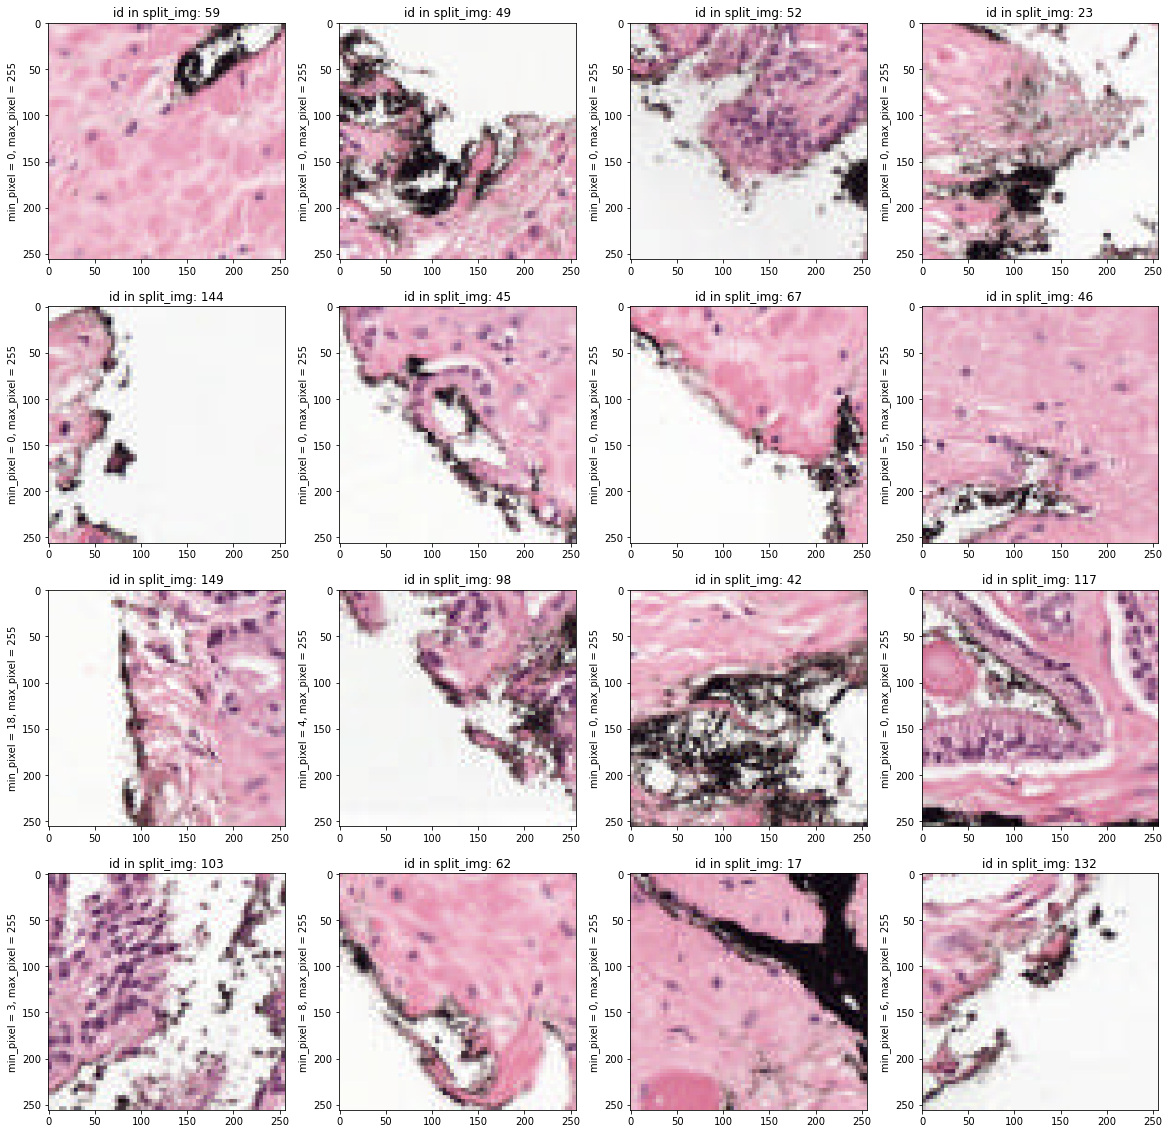

In [19]:
plt.figure(figsize = (20, 20))
for i in range(16):
    idx = np.random.randint(0, len(y1))
    plt.subplot(4, 4, i + 1)
    plt.imshow(y1[idx])
    plt.title('id in split_img: ' + str(idx))
    plt.ylabel('min_pixel = ' + str(y1[idx].min()) + ', max_pixel = ' + str(y1[idx].max()))

### 3. Build `get_tiles` function with `n_tiles = 81`

Target: Extract `tiles` & `coresponding masks_img` simultaneous!!

In [20]:
tile_size = 256; mode = 0
h = 22321
w = 9000
pad_h = (tile_size - h % tile_size) % tile_size + ((tile_size * mode) // 2)
pad_w = pad_h
si = [[pad_h // 2, pad_h - pad_h // 2], [pad_w // 2,pad_w - pad_w//2], [0,0]]
print(si)
pad_h

[[103, 104], [103, 104], [0, 0]]


207

In [36]:
from skimage.transform import rescale, resize
def get_tiles(img_id, level, mode=0, n_tiles = 81, ops = 256):
        """
            Input: 
                    - img_id (str): image_id from the train dataset
                    - level (int): an integer in {0, 1, 2} corresponding to the level_downsamples {1, 4, 16}
                    - mode (int) : define the quantities of pad_height & pad_width
                    - n_tiles (int): number of tiles (must be a squared_number)
                    - ops (int) : output_size of each image
            return: 
                    - list of img_data_tiles
                    - img_mask
                    - bool
        """
        tile_size = int(256 / 2**(2*level))
        data_img = skimage.io.MultiImage(os.path.join(data_dir, f'{img_id}.tiff'))[level]
        mask_img = skimage.io.MultiImage(os.path.join(mask_dir, f'{img_id}_mask.tiff'))[level]
        #mask_img = mask_img * (255 / mask_img.max())
        print('min_pixel_input_img_data : ', data_img.min(), ',\t\t max_pixel_input_img_data : ', data_img.max())
        print('min_pixel_input_img_mask : ', mask_img.min(), ',\t\t max_pixel_input_img_mask : ', mask_img.max())
        
        image_data_ls = []; image_mask_ls = []
        
        h, w = data_img.shape[:2]
        pad_h = (tile_size - h % tile_size) % tile_size + ((tile_size * mode) // 2)
        pad_w = (tile_size - w % tile_size) % tile_size + ((tile_size * mode) // 2)

        img2_dt_ = np.pad(data_img,[[pad_h // 2, pad_h - pad_h // 2], [pad_w // 2,pad_w - pad_w//2], [0,0]], constant_values = 255)
        img2_ms_ = np.pad(mask_img,[[pad_h // 2, pad_h - pad_h // 2], [pad_w // 2,pad_w - pad_w//2], [0,0]], constant_values = mask_img.max())
        
        img3_dt_ = img2_dt_.reshape(img2_dt_.shape[0] // tile_size, tile_size,
                                    img2_dt_.shape[1] // tile_size, tile_size,
                                    3 )
        img3_ms_ = img2_ms_.reshape(img2_ms_.shape[0] // tile_size, tile_size,
                                    img2_ms_.shape[1] // tile_size, tile_size,
                                    3 )
        
        img3_dt_ = img3_dt_.transpose(0,2,1,3,4).reshape(-1, tile_size, tile_size,3)
        img3_ms_ = img3_ms_.transpose(0,2,1,3,4).reshape(-1, tile_size, tile_size,3)
        
        n_tiles_with_info = (img3_dt_.reshape(img3_dt_.shape[0],-1).sum(1) < tile_size ** 2 * 3 * 255).sum()
        
        if len(img) < n_tiles:
            img3_dt_ = np.pad(img3_dt_,[[0,N - len(img3_dt_)],[0,0],[0,0],[0,0]], constant_values=255)
            img3_ms_ = np.pad(img3_ms_,[[0,N - len(img3_ms_)],[0,0],[0,0],[0,0]], constant_values = mask_img.max())
            
        idxs_dt_ = np.argsort(img3_dt_.reshape(img3_dt_.shape[0],-1).sum(-1))[:n_tiles]    
        
        img3_dt_ = img3_dt_[idxs_dt_]
        img3_ms_ = img3_ms_[idxs_dt_]
        print('min_pixel_output_img_data : ', img3_dt_.min(), ',\t min_pixel_output_img_data : ', img3_dt_.max())
        print('min_pixel_output_img_mask : ', img3_ms_.min(), ',\t min_pixel_output_img_mask : ', img3_ms_.max())
        
        for i in range(len(img3_dt_)):
            img4_dt_ = cv2.resize(img3_dt_[i], (ops, ops))
            image_data_ls.append({'img':img4_dt_, 'idx':i})
            img4_ms_ = cv2.resize(img3_ms_[i], (ops, ops))
            image_mask_ls.append({'img':img4_ms_, 'idx':i})
        
        return image_data_ls, image_mask_ls, n_tiles_with_info >= n_tiles
    

%time z = get_tiles('004dd32d9cd167d9cc31c13b704498af', 1); 
type(z), z[0][0]['img'].min(), z[0][0]['img'].max()

min_pixel_input_img_data :  0 ,		 max_pixel_input_img_data :  255
min_pixel_input_img_mask :  0 ,		 max_pixel_input_img_mask :  2
min_pixel_output_img_data :  0 ,	 min_pixel_output_img_data :  255
min_pixel_output_img_mask :  0 ,	 min_pixel_output_img_mask :  2
CPU times: user 396 ms, sys: 65.2 ms, total: 462 ms
Wall time: 385 ms


(tuple, 1, 255)

In [22]:
type(z[0]), len(z[0]), type(z[1]), len(z[1]), type(z[-1]), type(z[0][1])

(list, 81, list, 81, numpy.bool_, dict)

In [23]:
z[-1]

True

(256, 256, 3) 1 255 0 2


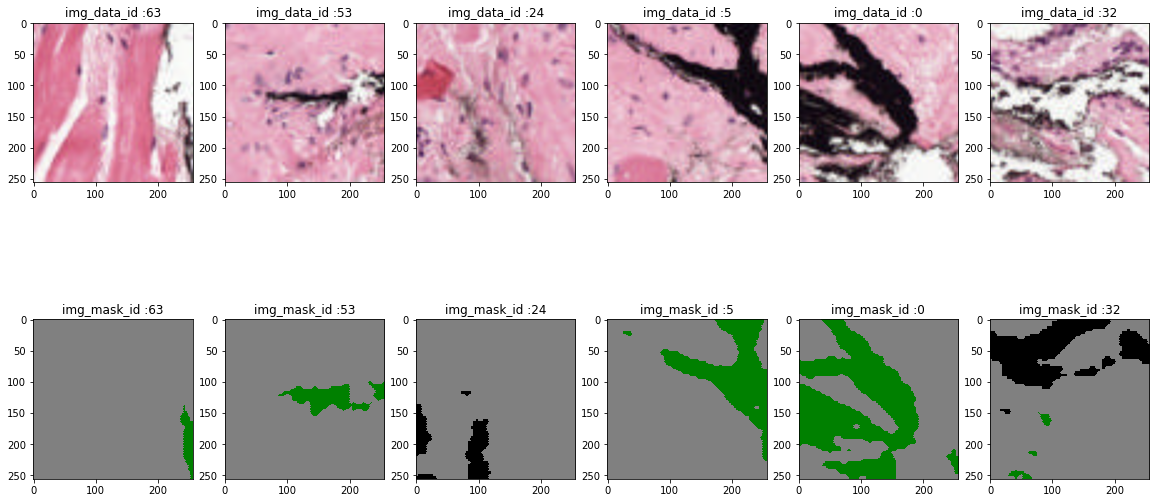

In [37]:
print(z[0][0]['img'].shape, z[0][0]['img'].min(), z[0][0]['img'].max(), z[1][0]['img'].min(), z[1][0]['img'].max())
cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])
plt.figure(figsize = (20, 10))
for k in range(6):
    idx = np.random.randint(0, len(z[0]))
    plt.subplot(2,6,k+1), plt.title('img_data_id :'+str(idx))
    plt.imshow(z[0][idx]['img'])
    
    plt.subplot(2,6,k+7), plt.title('img_mask_id :'+str(idx))
    plt.imshow(z[1][idx]['img'][:,:,0], cmap=cmap, interpolation='nearest', vmin=0, vmax=5)


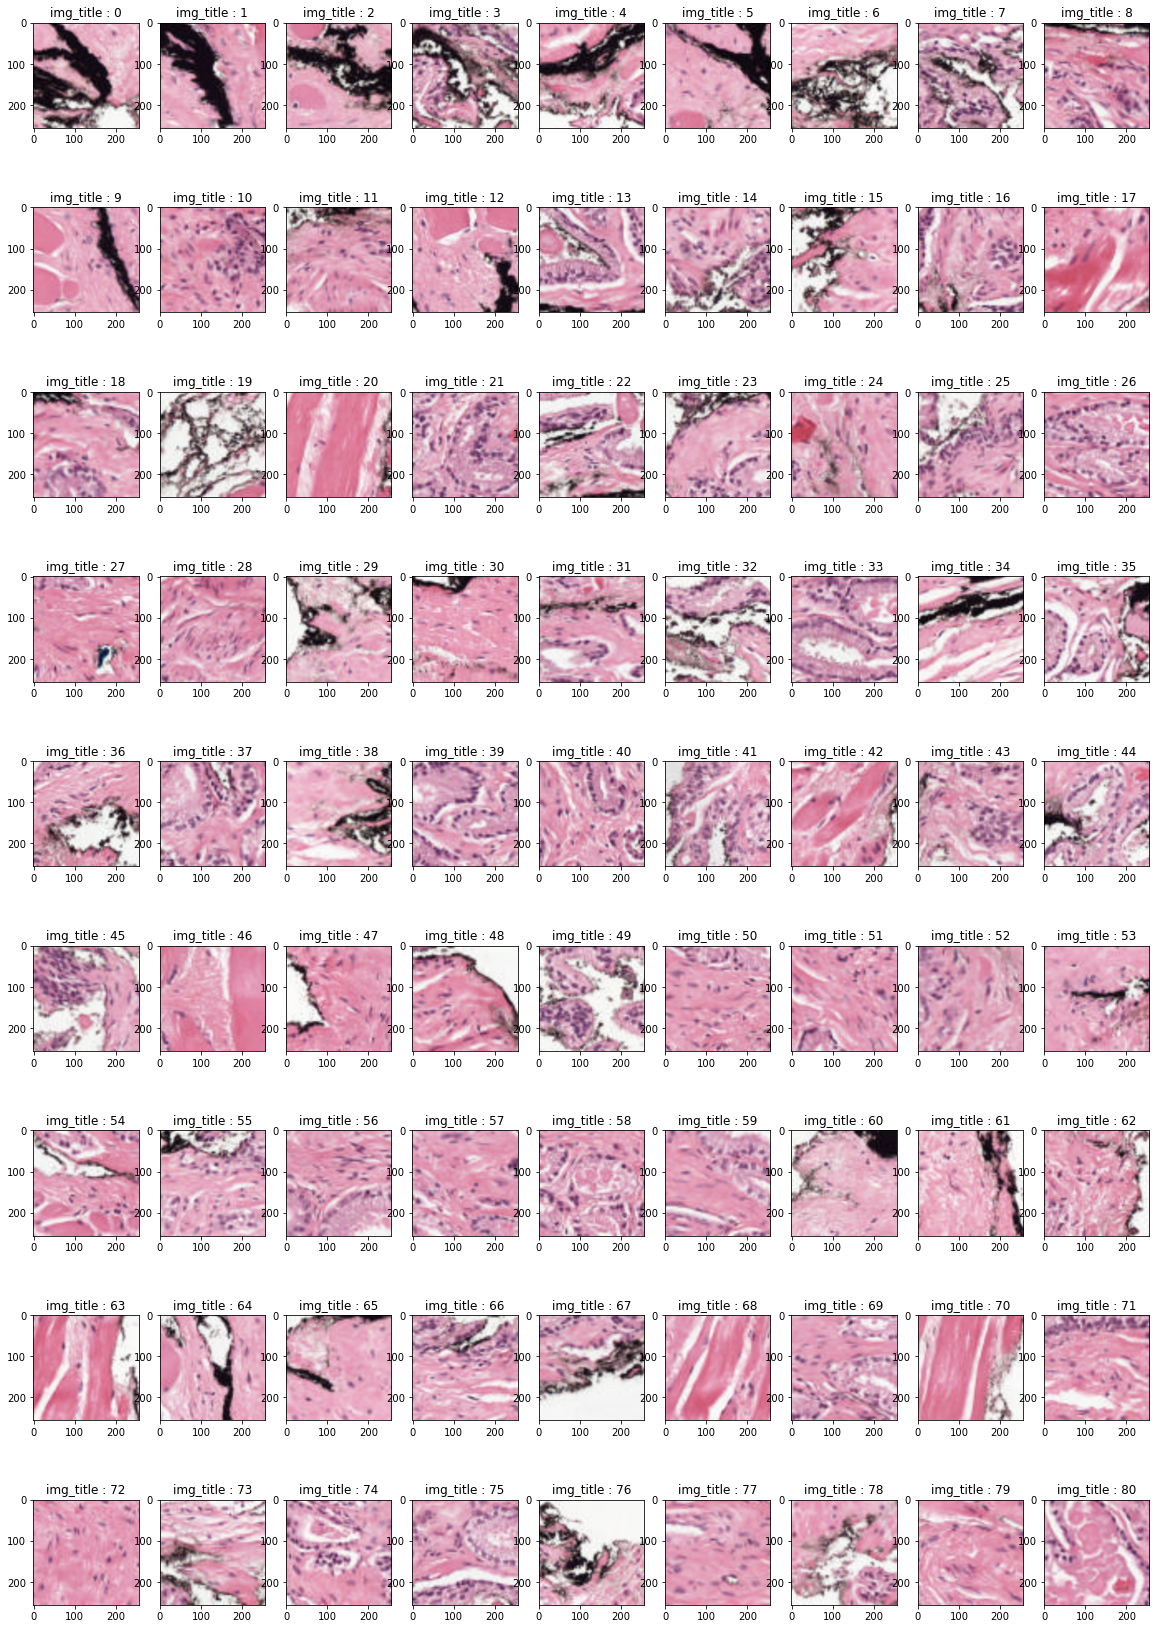

In [25]:
plt.figure(figsize = (20, 30))
for k in range(81):
    plt.subplot(9, 9, k + 1)
    plt.imshow(z[0][k]['img'])
    plt.title('img_title : ' + str(z[0][k]['idx']))

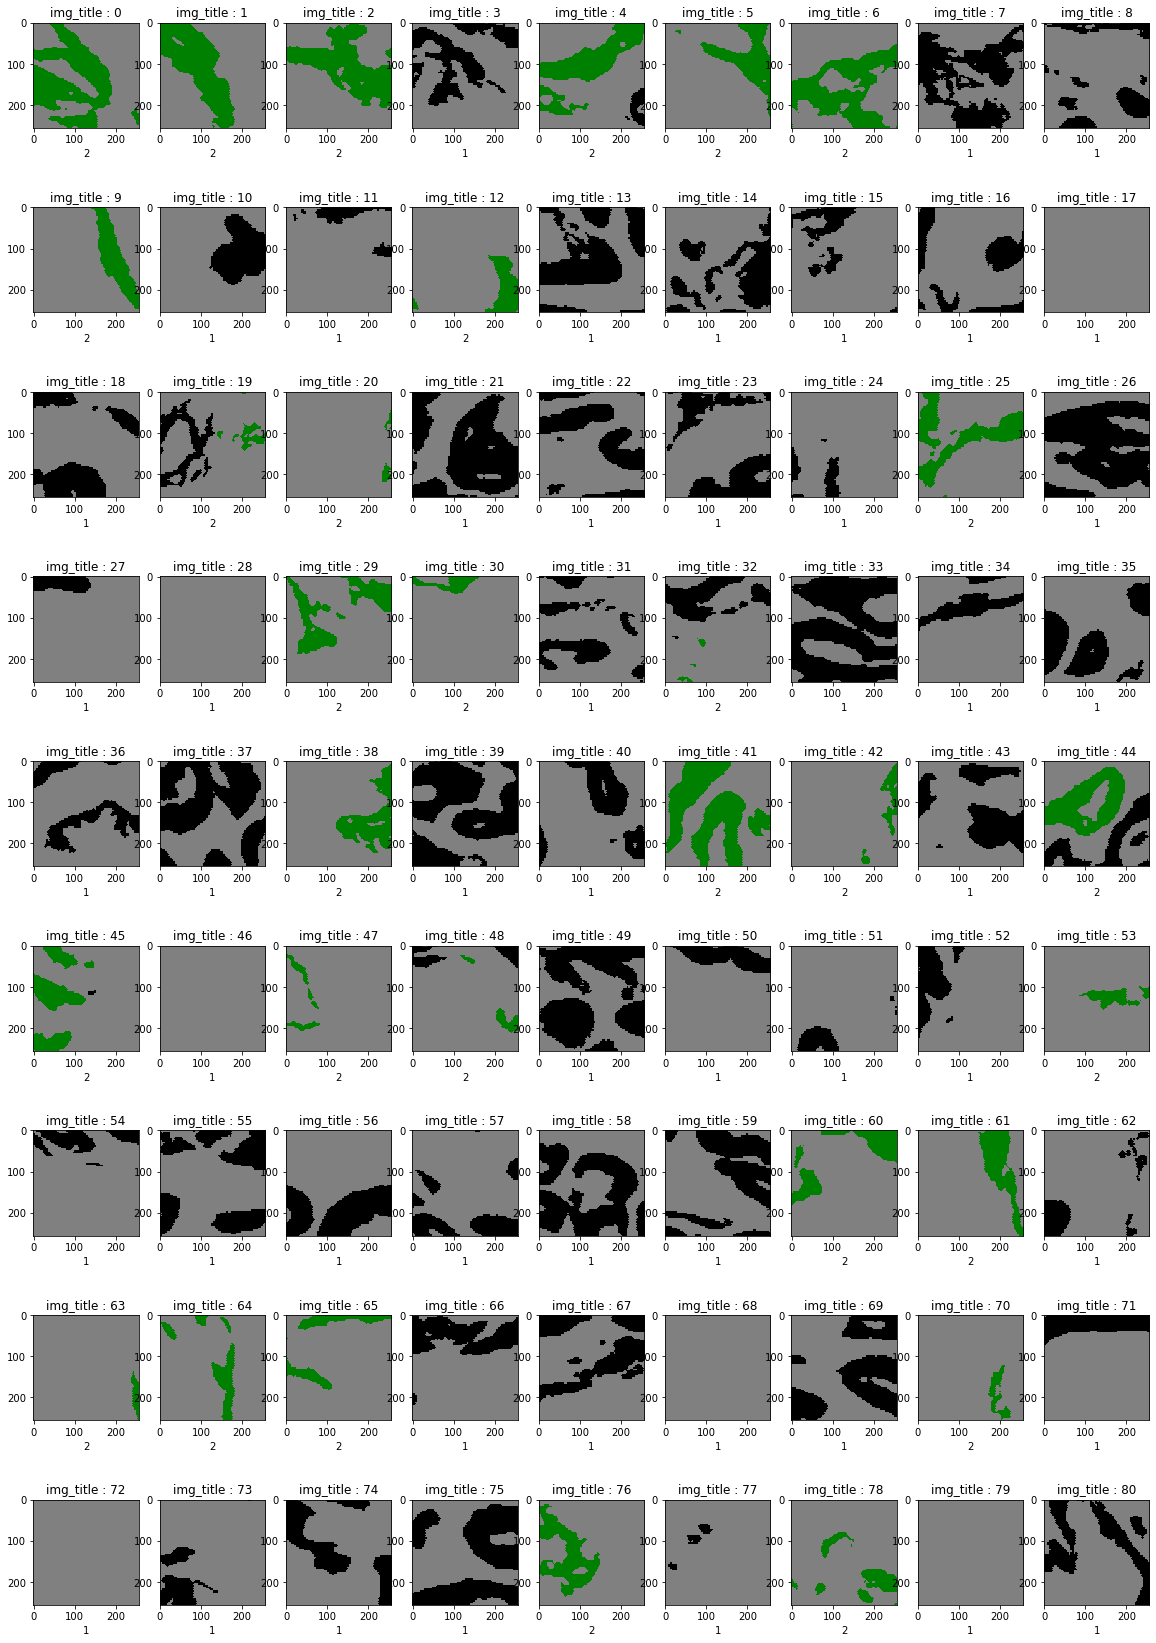

In [26]:
cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])
plt.figure(figsize = (20, 30))
for k in range(81):
    plt.subplot(9, 9, k + 1)
    plt.imshow(z[1][k]['img'][:,:,0], cmap=cmap, interpolation='nearest', vmin=0, vmax=5)
    plt.title('img_title : ' + str(z[1][k]['idx']))    
    plt.xlabel(str(z[1][k]['img'].max()))

#### and for `n_tiles = 25` & `img_id = '046b35ae95374bfb48cdca8d7c83233f'`

In [34]:
%time z = get_tiles('004dd32d9cd167d9cc31c13b704498af', 0, n_tiles = 25); 

z[0][0]['img'].min(), z[0][0]['img'].max()

min_pixel_input_img_data :  0 ,		 max_pixel_input_img_data :  255
min_pixel_input_img_mask :  0 ,		 max_pixel_input_img_mask :  2
min_pixel_output_img_data :  0 ,	 min_pixel_output_img_data :  255
min_pixel_output_img_mask :  0 ,	 min_pixel_output_img_mask :  2
CPU times: user 5.59 s, sys: 1.42 s, total: 7.01 s
Wall time: 5.74 s


(0, 255)

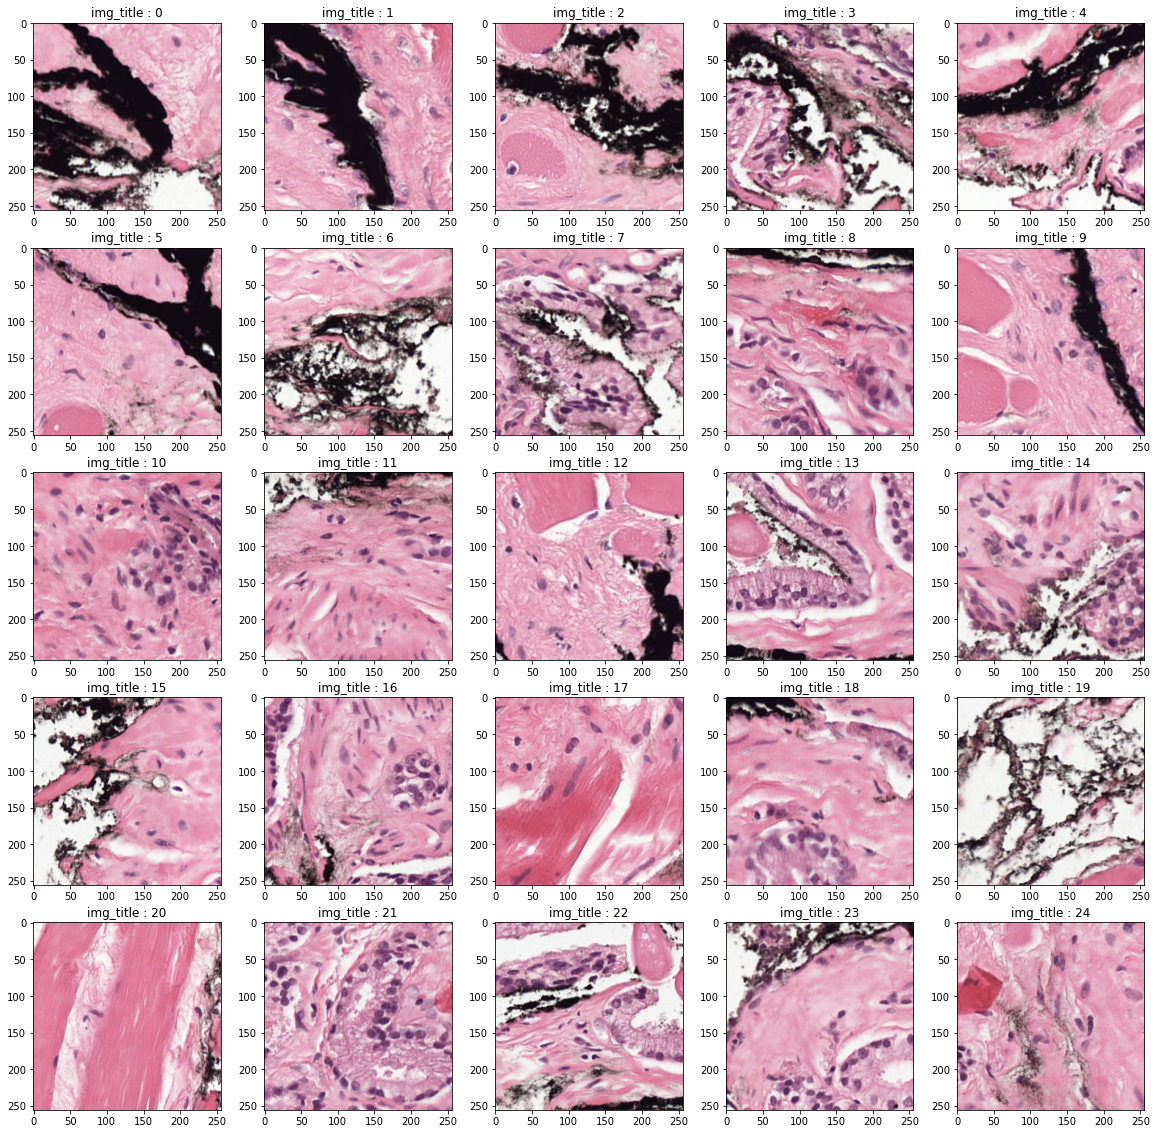

In [35]:
plt.figure(figsize = (20, 20))
for k in range(25):
    plt.subplot(5, 5, k + 1)
    plt.imshow(z[0][k]['img'])
    plt.title('img_title : ' + str(z[0][k]['idx']))

## 4. Create database

### 4.1. pytable & hdf5